Import libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import seaborn as sns
from datetime import datetime

In [16]:
LONG = 20
LAT = 66

data_dir = 'data/tomo/numeric_result/*.json' 


# Create an empty list to store filtered DataFrames
filtered_dfs = []
index=1

# Iterate through all files in the directory
for file_path in glob.glob(data_dir):
    pros=(index/len(glob.glob(data_dir))*100) 
    
    with open(file_path, 'r') as f:

        data = json.load(f)
        df = pd.DataFrame(
            {'lat': data['lat'], 
            'alt': data['alt'],
            'tec': data['ne'],
            'long': data['long']
            })
        df = df.loc[df['long'] == LONG]
        df=df.drop(columns=['long'])
        
        # Check if 't_end' contains only date or both date and time
        if len(data['t_end'][0].split(' ')) == 1:
            df['datetime'] = pd.to_datetime(data['t_end'][0] + ' 00:00:00')
        else:
            df['datetime'] = pd.to_datetime(data['t_end'][0])

        
        # Add the filtered DataFrame to the list
        filtered_dfs.append(df)

        index += 1
    print(f'Reading files... {pros:2f}% done', end='\r')

In [17]:
# Concatenate the filtered DataFrames into a single DataFrame
df = pd.concat(filtered_dfs, ignore_index=True)
df.iloc[215823:217141]

,lat,alt,tec,datetime
215823,80.0,25,0.0000,2023-01-20 23:55:00
215824,55.0,800,0.0401,2023-01-21 00:00:00
215825,55.5,800,0.0310,2023-01-21 00:00:00
215826,56.0,800,0.0212,2023-01-21 00:00:00
215827,56.5,800,0.0109,2023-01-21 00:00:00
...,...,...,...,...
217136,77.0,25,0.0000,2023-01-21 00:00:00
217137,78.0,25,0.0000,2023-01-21 00:00:00
217138,79.0,25,0.0000,2023-01-21 00:00:00
217139,80.0,25,0.0000,2023-01-21 00:00:00


In [18]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.drop_duplicates(subset=['lat', 'datetime'], keep='first')

# Display the resulting DataFrame
print(df.head(5))

    lat  alt     tec            datetime
0  55.0  800  0.1558 2023-01-20 10:20:00
1  55.5  800  0.1463 2023-01-20 10:20:00
2  56.0  800  0.1360 2023-01-20 10:20:00
3  56.5  800  0.1250 2023-01-20 10:20:00
4  57.0  800  0.1138 2023-01-20 10:20:00


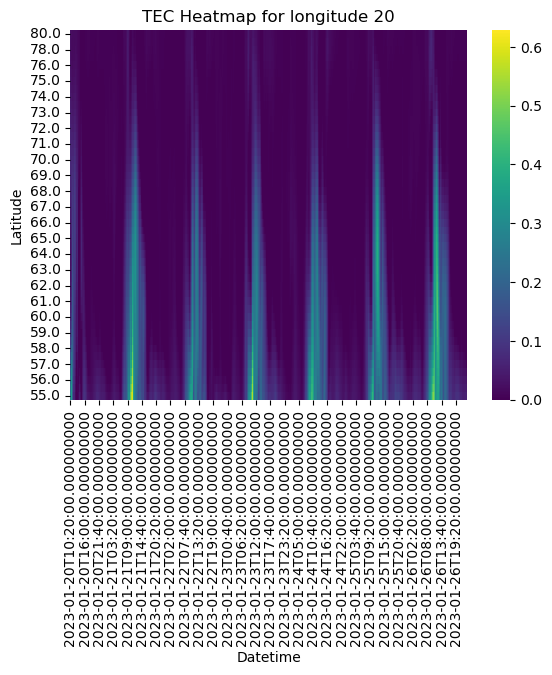

In [19]:
pivot1 = df.pivot(index='lat', columns='datetime', values='tec')
sns.heatmap(pivot1, cmap='viridis')

plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'TEC Heatmap for longitude {LONG}')
plt.gca().invert_yaxis()

plt.show()

In [20]:
rolling_df = pd.DataFrame()

for lat in df['lat'].unique():
    df5 = df.loc[df['lat'] == lat]
    moving_avg = df5['tec'].rolling(window=36, min_periods=1, center=True).mean()
    rolling_df = pd.concat([rolling_df, moving_avg], axis=0)

df = pd.concat([df, rolling_df], axis=1)
df['rolling'] = df[0]
df = df.drop(columns=[0])

In [21]:
df['detrended_tec'] = df['tec'] - df['rolling']
df['detrended_tec'].describe()

count    88783.000000
mean        -0.000018
std          0.019578
min         -0.107506
25%         -0.003011
50%         -0.000225
75%          0.001669
max          0.229544
Name: detrended_tec, dtype: float64

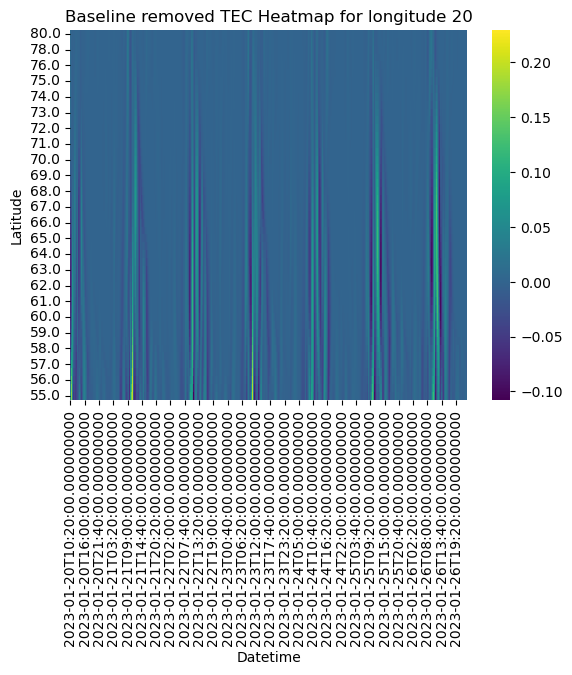

In [22]:
pivot = df.pivot(index='lat', columns='datetime', values='detrended_tec')
sns.heatmap(pivot, cmap='viridis')

plt.gca().invert_yaxis()
plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'Baseline removed TEC Heatmap for longitude {LONG}')

plt.show()

In [23]:
# path2 = 'data/ruots/gotaland.csv'
path2 = 'data/ruots/norra_norrland.csv'
# path2 = 'data/ruots/sodra_norrland.csv'
# path2 = 'data/ruots/svealand.csv'

dfv = pd.read_csv(path2, header=None, sep=';')

DT1, DT2 = df['datetime'].unique()[0], df['datetime'].unique()[-1]

dfv['datetime'] = pd.to_datetime(dfv[0])
dfv['i95'] = dfv[1].str.replace(',', '.').astype(float)
dfv.drop([0, 1], axis=1, inplace=True)
dfv = dfv.loc[(dfv['datetime'] >= DT1) & (dfv['datetime'] <= DT2)]

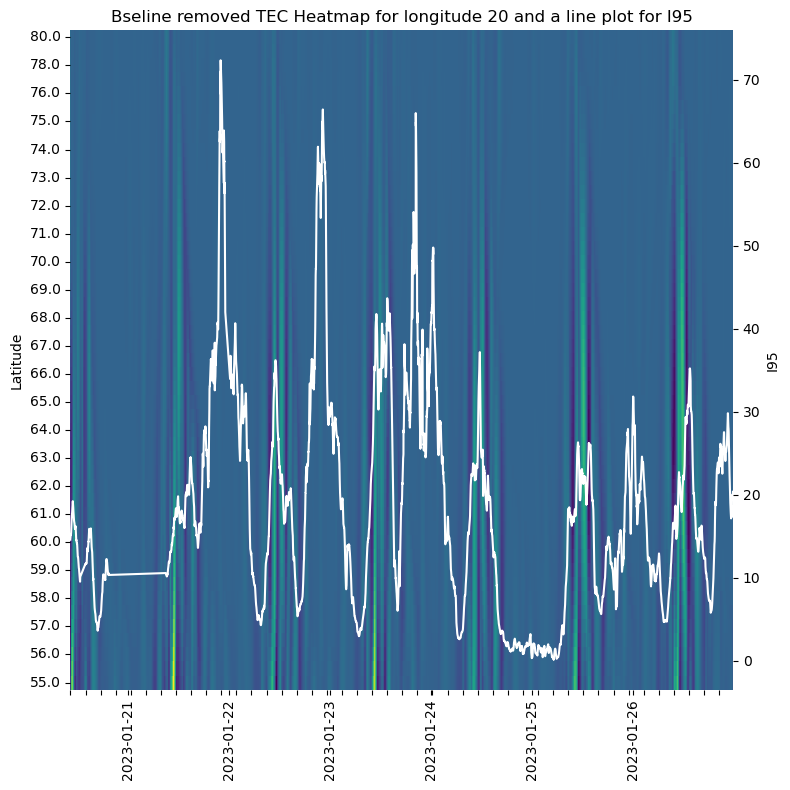

In [24]:
check = False
indices = [len(df['datetime'].unique().tolist())/6*i for i in range(1,6)]
checklist = [str(df['datetime'].unique().tolist()[math.ceil(index)]) for index in indices]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pivot = df.pivot(index='lat', columns='datetime', values='detrended_tec')

min_x = df['datetime'].min()
max_x = df['datetime'].max()

ax.set_xlim(min_x, max_x)
g1 = sns.heatmap(pivot, cmap='viridis', ax=ax, cbar=False)
ax.invert_yaxis()
g1.set(xlabel=None, ylabel = 'Latitude', 
title = f'Baseline removed TEC Heatmap for longitude {LONG} and a line plot for I95')
ax.set_xticklabels([])

checklist = ['2023-01-20 12:00:00', '2023-01-21 12:00:00', '2023-01-22 12:00:00', 
'2023-01-23 12:00:00', '2023-01-24 12:00:00', '2023-01-25 12:00:00','2023-01-26 12:00:00']

if check:
    for date in checklist:

        x = df['datetime'].unique().tolist().index(datetime.strptime(date, '%Y-%m-%d %H:%M:%S'))
        ax.axvline(x=x, color='red', lw=5)


ax2 = fig.add_subplot(111)
ax2.plot(dfv['datetime'], dfv['i95'], color='white', zorder=10, lw=1.5)
ax2.yaxis.set_label_text('I95')
plt.xticks(rotation =90)
ax2.set_xlim(min_x, max_x)
ax2.yaxis.tick_right()
ax2.grid(False)
ax2.patch.set_alpha(0.0) #type: ignore
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_label_position("right")

if check:
        for date in checklist:
            ax2.axvline(x=np.datetime64(date).tolist(), color='black', zorder=5, lw=1)
    


plt.tight_layout()

plt.show()

In [27]:
df1 = df.loc[(df['lat'] == LAT)]

moving_avg = df5['tec'].rolling(window=18, min_periods=1, center=True).mean()

# Subtract the moving average from the original values
df5['detrended_tec'] = df5['tec'] - moving_avg
df5


,lat,alt,tec,datetime,detrended_tec
46,80.0,800,0.0293,2023-01-20 10:20:00,0.006667
1362,80.0,800,0.0266,2023-01-20 10:25:00,0.004170
2678,80.0,800,0.0234,2023-01-20 10:30:00,0.001345
3994,80.0,800,0.0209,2023-01-20 10:35:00,-0.000675
5310,80.0,800,0.0201,2023-01-20 10:40:00,-0.001077
...,...,...,...,...,...
2479390,80.0,800,0.0023,2023-01-26 23:20:00,-0.000729
2480706,80.0,800,0.0023,2023-01-26 23:25:00,-0.000685
2482022,80.0,800,0.0024,2023-01-26 23:30:00,-0.000525
2483338,80.0,800,0.0026,2023-01-26 23:35:00,-0.000255


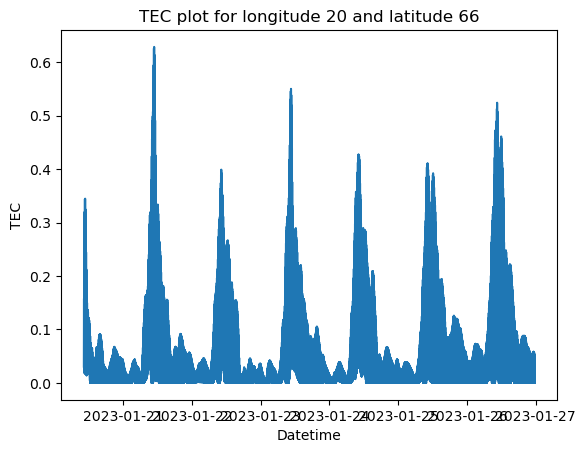

In [28]:
plt.plot(df['datetime'], df['tec'])
#plt.plot(df5.index, moving_avg)
plt.xlabel('Datetime')
plt.ylabel('TEC')
plt.title(f'TEC plot for longitude {LONG} and latitude {LAT}')
plt.show()

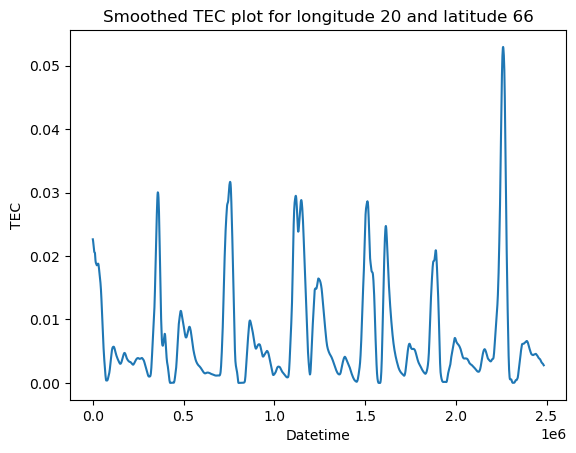

In [29]:
plt.plot(df5.index, moving_avg)
plt.xlabel('Datetime')
plt.ylabel('TEC')
plt.title(f'Smoothed TEC plot for longitude {LONG} and latitude {LAT}')
plt.show()